In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import torch
# from heat_solver import solve_heat_equation
from heat_solver import HeatSolver
from utils import (
    verification_solution, verification_source, compute_l2_error, 
    compute_relative_error, visualize_solution, visualize_comparison, plot_convergence_analysis,
    print_solver_info, create_conductivity_field
)

from utils import SimpleSigma, SigmoidSigma

import matplotlib.pyplot as plt

In [3]:
device = 'cpu'

In [6]:
%%time
# Create conductivity field
M = 10
sigma = create_conductivity_field(M, pattern='constant')
sigma.requires_grad_(True)

solver = HeatSolver(M, verification_source, device)

# Solve heat equation
u_final, u_b_history = solver(sigma, T=1.0, max_sigma=5)

print(f"Final temperature range: [{u_final.min():.4f}, {u_final.max():.4f}]")

Final temperature range: [-0.6216, 0.6216]
CPU times: total: 3.2 s
Wall time: 2.44 s


In [7]:
h = 1.0 / M
x = torch.linspace(0, 1, M+1, device=device)[:-1] + h/2
y = torch.linspace(0, 1, M+1, device=device)[:-1] + h/2
X, Y = torch.meshgrid(x, y, indexing='ij')

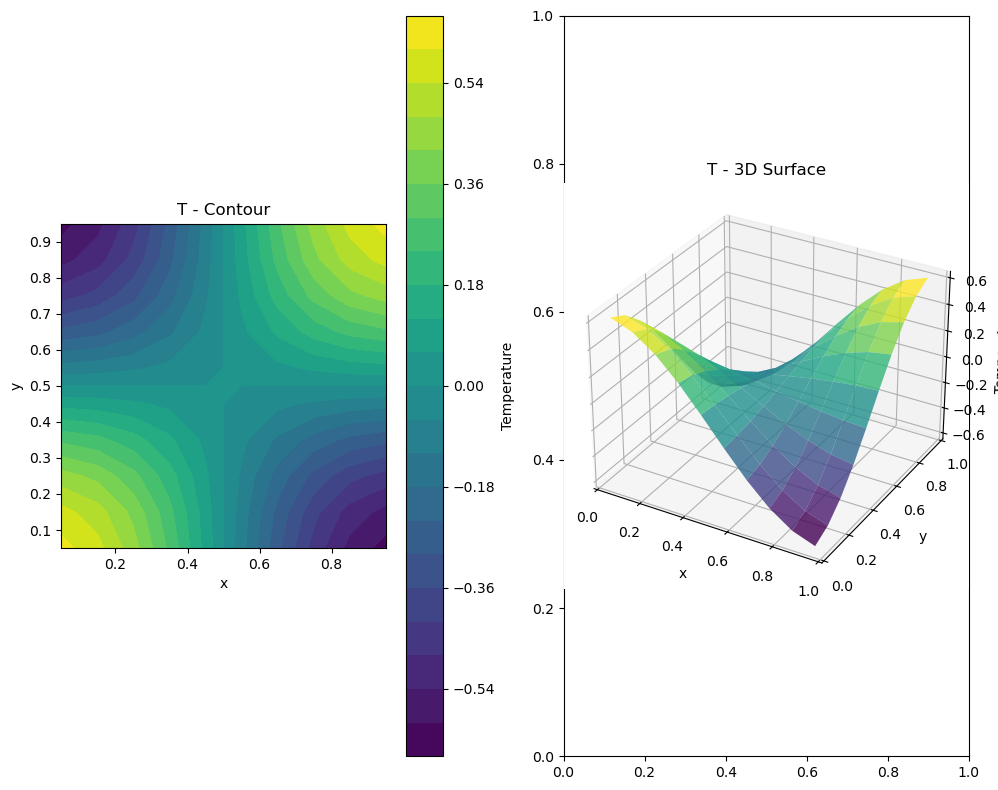

In [8]:
visualize_solution(u_final.detach().numpy(), X.detach().numpy(), Y.detach().numpy(), "T")

In [9]:
from inverse_solver import InverseSolver

In [10]:
u_final.shape

torch.Size([10, 10])

In [11]:
u_b_history.shape

torch.Size([4001, 36])

In [16]:
sigma = SimpleSigma(M, 1.0)

In [20]:
inv_solver = InverseSolver(
    sigma,
    u_b_history.detach(),
    verification_source,
    M=M,
    T=1.0,
    n_steps=u_b_history.shape[0] - 1,
    lr=0.1,
    alpha=0.001,
    sigma_0=2,
    device=device,
)

In [21]:
final_sigma, total_loss_history, boundary_loss_history, regularization_loss_history = inv_solver.solve(max_iters=20)

  0%|          | 0/20 [00:00<?, ?it/s]

1.0 4000


  5%|▌         | 1/20 [00:05<01:38,  5.17s/it]

Iter 0: Loss = 0.001229
1.0 4000


 10%|█         | 2/20 [00:10<01:35,  5.31s/it]

Iter 1: Loss = 0.002240
1.0 4000


 15%|█▌        | 3/20 [00:16<01:31,  5.38s/it]

Iter 2: Loss = 0.001271
1.0 4000


 20%|██        | 4/20 [00:21<01:25,  5.34s/it]

Iter 3: Loss = 0.001144
1.0 4000


 25%|██▌       | 5/20 [00:26<01:20,  5.38s/it]

Iter 4: Loss = 0.001513
1.0 4000


 30%|███       | 6/20 [00:32<01:15,  5.42s/it]

Iter 5: Loss = 0.001434
1.0 4000


 35%|███▌      | 7/20 [00:37<01:10,  5.43s/it]

Iter 6: Loss = 0.001106
1.0 4000


 40%|████      | 8/20 [00:43<01:05,  5.45s/it]

Iter 7: Loss = 0.001014
1.0 4000


 45%|████▌     | 9/20 [00:48<01:00,  5.47s/it]

Iter 8: Loss = 0.001167
1.0 4000


 50%|█████     | 10/20 [00:54<00:54,  5.47s/it]

Iter 9: Loss = 0.001249
1.0 4000


 55%|█████▌    | 11/20 [00:59<00:48,  5.43s/it]

Iter 10: Loss = 0.001144
1.0 4000


 55%|█████▌    | 11/20 [01:04<00:53,  5.91s/it]


Converged at iteration 11, loss: 0.000989


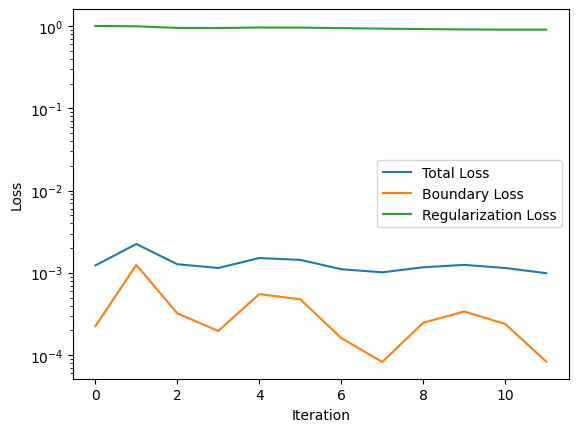

In [22]:
plt.plot(total_loss_history, label='Total Loss')
plt.plot(boundary_loss_history, label='Boundary Loss')
plt.plot(regularization_loss_history, label='Regularization Loss')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
final_sigma

array([[1.045275  , 1.1621697 , 1.015276  , 0.9471044 , 1.0086946 ,
        0.98834455, 0.93915987, 1.1904725 , 1.023141  , 1.2874955 ],
       [0.98808247, 0.9591446 , 0.835081  , 0.95118   , 1.0905575 ,
        1.0174772 , 0.96399385, 0.80625504, 1.0662271 , 1.0519043 ],
       [0.90051866, 0.8472418 , 1.001261  , 1.060129  , 1.0044082 ,
        0.9628807 , 1.076941  , 1.1050172 , 0.9202092 , 1.0675921 ],
       [1.0030929 , 1.1094643 , 1.136241  , 1.0863957 , 1.0802115 ,
        1.2600286 , 1.0701785 , 1.0568514 , 0.9880644 , 0.94327223],
       [0.87357986, 0.93957204, 0.8761536 , 1.0104151 , 1.3691317 ,
        1.6537819 , 1.6557199 , 0.9909333 , 0.88151807, 1.0807517 ],
       [1.0648073 , 0.95850956, 1.3108164 , 1.9501479 , 1.6796299 ,
        1.4558216 , 1.0108416 , 1.0194075 , 0.9060504 , 0.88711   ],
       [1.0032027 , 0.9494795 , 1.1945002 , 1.1027675 , 1.2580569 ,
        1.2066538 , 1.166845  , 0.9018313 , 1.0576371 , 1.1501354 ],
       [1.2251308 , 0.7859958 , 0.7521305

In [24]:
from test_solver import *

Testing Heat Solver Accuracy
Solving heat equation...
N time steps 801
Grid: 10x10, Time step: 0.001248, Steps: 801
L2 Error: 0.002537
Relative Error: 0.008026
HEAT SOLVER INFORMATION
Grid size: 10 x 10
Grid spacing: h = 0.1000
Total time: T = 1.0
Time step: τ = 0.001247
Number of steps: 802
Maximum conductivity: σ_max = 1.0000
Stability limit: τ_max = 0.002500
CFL number: 0.4988


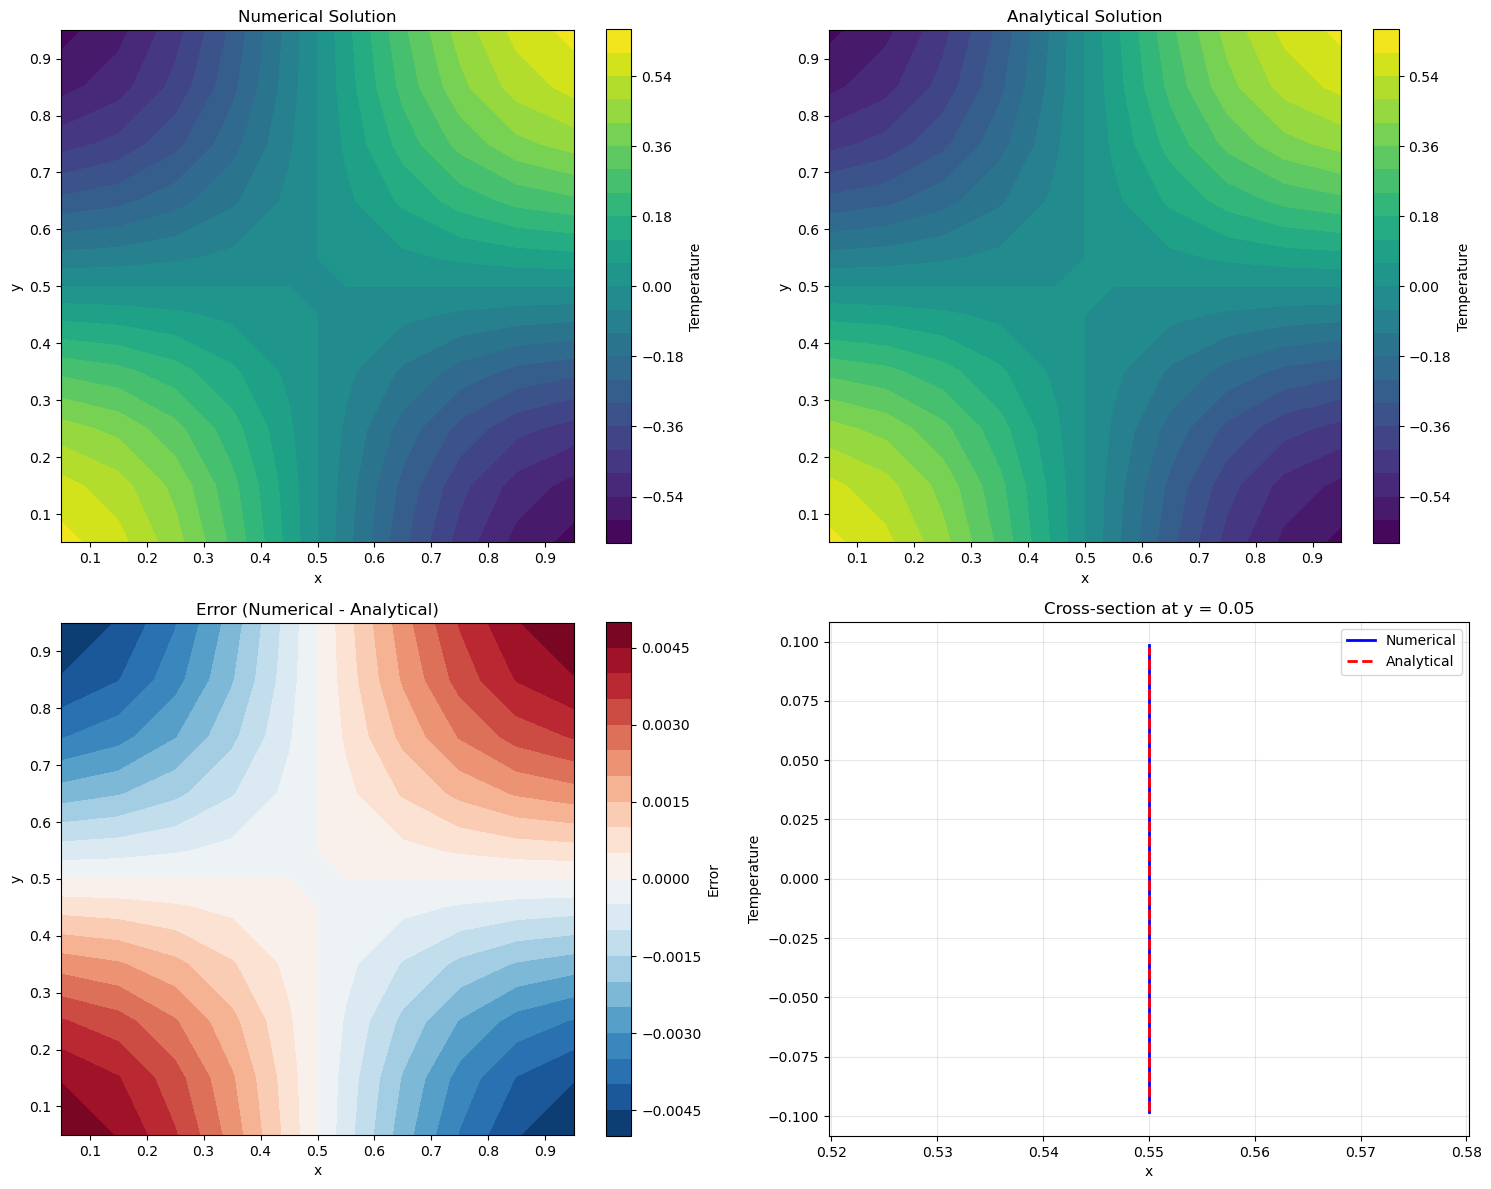

In [25]:
l2_error, relative_error = test_solver_accuracy()

In [26]:
print(f"L2 Error: {l2_error:.6f}, Relative Error: {relative_error:.6f}")

L2 Error: 0.002537, Relative Error: 0.008026



Testing Convergence Rate
Testing M = 5...
N time steps 201
Grid: 5x5, Time step: 0.004975, Steps: 201
  h = 0.2000, Error = 0.010292
Testing M = 10...
N time steps 801
Grid: 10x10, Time step: 0.001248, Steps: 801
  h = 0.1000, Error = 0.002537
Testing M = 20...
N time steps 3201
Grid: 20x20, Time step: 0.000312, Steps: 3201
  h = 0.0500, Error = 0.000632
Testing M = 40...
N time steps 12801
Grid: 40x40, Time step: 0.000078, Steps: 12801
  h = 0.0250, Error = 0.000157


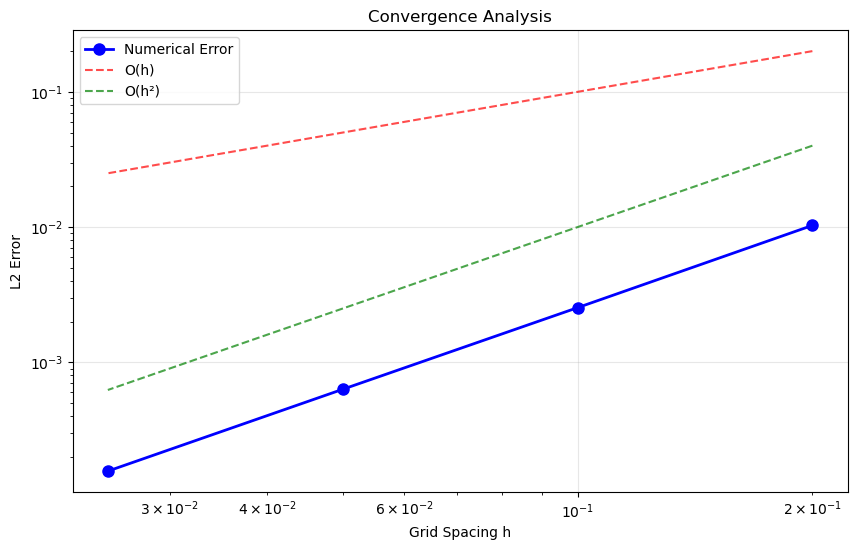

Convergence rate: 2.01


In [27]:
h_values, errors = test_convergence()